# Assignment 1

In [1]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/Colab Notebooks/rl/assignment1_release" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [3]:
%matplotlib inline
import warnings

from dataclasses import dataclass
import torch
from torch import optim
from torchvision.datasets import CIFAR10
from torchvision import transforms
from utils import seed_experiment, to_device, cross_entropy_loss, compute_accuracy
from config import get_config_parser
import json
from mlp import MLP
from resnet18 import ResNet18
from mlpmixer import MLPMixer
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
import os

# Local Test
Before run the experiment, here are some local test cases you can run for sanity check

In [4]:
import unittest
import test
suite = unittest.TestLoader().loadTestsFromModule(test)
unittest.TextTestRunner(verbosity=2).run(suite)

test_linear_attributes (test.TestLinear) ... ok
test_linear_forward (test.TestLinear) ... ok
test_activation (test.TestMLP) ... ok
test_forward (test.TestMLP) ... ok
test_mlp (test.TestMLP) ... ok
test_mixer_block (test.TestMLPMixer) ... ok
test_mlpmixer (test.TestMLPMixer) ... 

ok
test_patch_emb (test.TestMLPMixer) ... ok
test_basic_block (test.TestResNet) ... ok
test_basic_block2 (test.TestResNet) ... ok
test_resnet (test.TestResNet) ... ok
test_ce_loss (test.TestUtils) ... ok

----------------------------------------------------------------------
Ran 12 tests in 1.902s

OK


<unittest.runner.TextTestResult run=12 errors=0 failures=0>

## Experiments

Below we define a few default arguments to get you started with your experiments. You are encouraged to modify the function `main_entry()`, as well as these arguments, to fit your needs (e.g. changing hyperparameters, the optimizer, adding regularizations).

In [6]:
@dataclass
class Arguments:
  # Data
  batch_size: int = 128
  # Model
  model: str = 'mlp'  # [mlp, resnet18, mlpmixer]
  model_config: str = "./model_configs/mlp.json" # path to model config json file

  # Optimization
  optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
  epochs: int = 15
  lr: float = 1e-3
  momentum: float = 0.9
  weight_decay: float = 5e-4

  # Experiment
  logdir: str = '/content/assignment/logs'
  seed: int = 42

  # Miscellaneous
  device: str = 'cuda'
  visualize : bool = False
  print_every: int = 80
  hyper_parameter: bool = True

In [8]:
!pip install skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 18.1 MB/s eta 0:00:00


In [11]:
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV
import torch.nn as nn

In [5]:
# Main code entry. Train the model and save the logs
from main import train, evaluate
def main_entry(args):
    # Check for the device
    if (args.device == "cuda") and not torch.cuda.is_available():
        warnings.warn(
            "CUDA is not available, make that your environment is "
            "running on GPU (e.g. in the Notebook Settings in Google Colab). "
            'Forcing device="cpu".'
        )
        args.device = "cpu"

    if args.device == "cpu":
        warnings.warn(
            "You are about to run on CPU, and might run out of memory "
            "shortly. You can try setting batch_size=1 to reduce memory usage."
        )

    # Seed the experiment, for repeatability
    seed_experiment(args.seed)

    test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
    # For training, we add some augmentation. Networks are too powerful and would overfit.
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                        ])
    # Loading the training dataset. We need to split it into a training and validation part
    # We need to do a little trick because the validation set should not use the augmentation.
    train_dataset = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
    val_dataset = CIFAR10(root='./data', train=True, transform=test_transform, download=True)
    train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
    _, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

    # Loading the test set
    test_set = CIFAR10(root='./data', train=False, transform=test_transform, download=True)
    
    # Load model
    print(f'Build model {args.model.upper()}...')
    if args.model_config is not None:
        print(f'Loading model config from {args.model_config}')
        with open(args.model_config) as f:
            model_config = json.load(f)
    else:
        raise ValueError('Please provide a model config json')
    print(f'########## {args.model.upper()} CONFIG ################')
    for key, val in model_config.items():
        print(f'{key}:\t{val}')
    print('############################################')
    model_cls = {'mlp': MLP, 'resnet18': ResNet18, 'mlpmixer': MLPMixer}[args.model]
    model = model_cls(**model_config)
    model.to(args.device)
    
    # Optimizer
    if args.optimizer == "adamw":
        optimizer = optim.AdamW(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    elif args.optimizer == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "momentum":
        optimizer = optim.SGD(
            model.parameters(),
            lr=args.lr,
            momentum=args.momentum,
            weight_decay=args.weight_decay,
        )
    
    print(
        f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
        f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
    )

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    train_times, valid_times = [], []
    
    # We define a set of data loaders that we can use for various purposes later.
    train_dataloader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    valid_dataloader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
    test_dataloader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
    for epoch in range(args.epochs):
        tqdm.write(f"====== Epoch {epoch} ======>")
        loss, acc, wall_time,  = train(epoch, model, train_dataloader, optimizer,args)
        train_losses.append(loss)
        train_accs.append(acc)
        train_times.append(wall_time)

        loss, acc, wall_time = evaluate(epoch, model, valid_dataloader,args)
        valid_losses.append(loss)
        valid_accs.append(acc)
        valid_times.append(wall_time)

    test_loss, test_acc, test_time = evaluate(
        epoch, model, test_dataloader, args, mode="test"
    )
    print(f"===== Best validation Accuracy: {max(valid_accs):.3f} =====>")

    # Save log if logdir provided
    if args.logdir is not None:
        print(f'Writing training logs to {args.logdir}...')
        os.makedirs(args.logdir, exist_ok=True)
        with open(os.path.join(args.logdir, 'results.json'), 'w') as f:
            f.write(json.dumps(
                {
                    "train_losses": train_losses,
                    "valid_losses": valid_losses,
                    "train_accs": train_accs,
                    "valid_accs": valid_accs,
                    "test_loss": test_loss,
                    "test_acc": test_acc
                },
                indent=4,
            ))

        # Visualize
        if args.visualize and args.model in ['resnet18', 'mlpmixer']:
            model.visualize(args.logdir)

        # Hyper-parameter
        if args.hyper_parameter and args.model in ['resnet18', 'mlpmixer']:
          # create model with skorch
          hyper_model = NeuralNetClassifier(
              model,
              criterion=nn.BCELoss,
              optimizer=optim.Adamax,
              max_epochs=10,
              batch_size=10,
              verbose=True
          )
          if args.model == 'resnet18':
            distributions = dict(lr=['0.0001', '0.001'], 
                                 momentum=['0.8', '0.9', '0.99'])
            clf = RandomizedSearchCV(hyper_model, distributions, random_state=0)
            search = clf.fit(iris.data, iris.target)

**Question 2**

In [ ]:
# Example to run MLP with 15 epochs(relu)
config = Arguments(model='mlp', 
                   model_config='assignment/model_configs/mlp.json', 
                   epochs=15, logdir="exps/mlp_default")
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLP...
Loading model config from assignment/model_configs/mlp.json
########## MLP CONFIG ################
input_size:	3072
hidden_sizes:	[1024, 512, 64, 64]
num_classes:	10
activation:	relu
############################################
Initialized MLP model with 3709194 total parameters, of which 3709194 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.53047
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.79490
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.84185
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.57127
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.78242
== [TRAIN] Epoch: 0, Accuracy: 0.355 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.70092
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.437 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.70316
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.49032
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.79979
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.79

In [ ]:
# Example to run MLP with 15 epochs(tanh)
config = Arguments(model='mlp', 
                   model_config='assignment/model_configs/mlp.json', 
                   epochs=15, logdir="exps/mlp_default")
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLP...
Loading model config from assignment/model_configs/mlp.json
########## MLP CONFIG ################
input_size:	3072
hidden_sizes:	[1024, 512, 64, 64]
num_classes:	10
activation:	tanh
############################################
Initialized MLP model with 3709194 total parameters, of which 3709194 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.40576
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.93324
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.94926
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.74711
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.80549
== [TRAIN] Epoch: 0, Accuracy: 0.337 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.79634
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.371 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.87984
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.83621
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.88771
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.91

In [ ]:
# Example to run MLP with 15 epochs(sigmoid)
config = Arguments(model='mlp', 
                   model_config='assignment/model_configs/mlp.json', 
                   epochs=15, logdir="exps/mlp_default")
main_entry(config)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Build model MLP...
Loading model config from assignment/model_configs/mlp.json
########## MLP CONFIG ################
input_size:	3072
hidden_sizes:	[1024, 512, 64, 64]
num_classes:	10
activation:	sigmoid
############################################
Initialized MLP model with 3709194 total parameters, of which 3709194 are learnable.
====== Epoch 0 ======>


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[TRAIN] Epoch: 0, Iter: 0, Loss: 2.41904
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.96175
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.95620
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.75708
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.84127
== [TRAIN] Epoch: 0, Accuracy: 0.310 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.82951
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.374 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.78926
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.68523
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.80989
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.81222
[TRAIN] Epoch: 1, Iter: 320, Loss: 1.64564
== [TRAIN] Epoch: 1, Accuracy: 0.396 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 1.75027
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.417 ===>
====== Epoch 2 ======>
[TRAIN] Epoch: 2, Iter: 0, Loss: 1.68400
[TRAIN] Epoch: 2, Iter: 80, Loss: 1.56892
[TRAIN] Epoch: 2, Iter: 160, Loss: 1.70833
[TRAIN] Epoch: 2, Iter: 240, Loss: 1.59963
[TRAIN] Epoch: 2, Iter: 320, Loss: 1.64490
== [TRAIN] Epoch: 2, Accuracy: 0.427 ==>
[VAL] Epoch: 2,

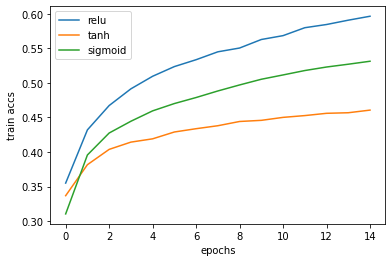

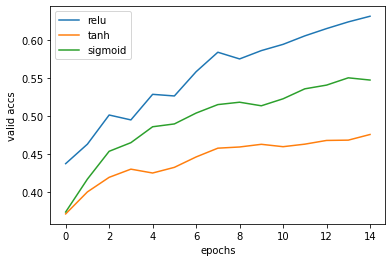

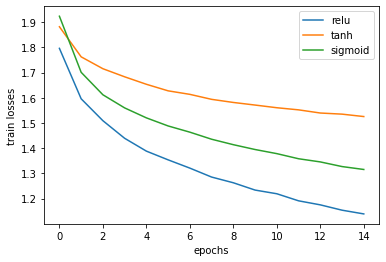

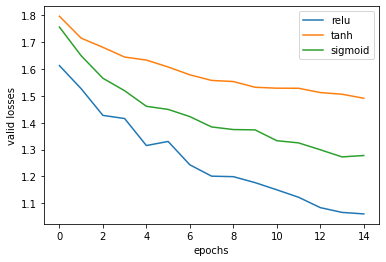

In [ ]:
import utils
utils.generate_plots(['/content/exps/mlp_default/relu', 
                      '/content/exps/mlp_default/tanh', 
                      '/content/exps/mlp_default/sigmoid'], 
                     ['relu', 'tanh', 'sigmoid'], 
                     '/content/gdrive/MyDrive/rl/assignment1_release/figure_save')

**Question 3**

In [ ]:
# Example to run ResNet18 with 15 epochs
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18")
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.50403
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.45186
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.36323
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.25550
== [TRAIN] Epoch: 0, Accuracy: 0.471 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.11870
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.606 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.97618
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.94893
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.05496
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.99508
[TRAIN] Epoch: 1, Iter: 320, Loss

In [ ]:
# Example to run ResNet18 with 15 epochs
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", lr=0.1)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 2.09520
[TRAIN] Epoch: 0, Iter: 160, Loss: 2.01041
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.78478
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.83323
== [TRAIN] Epoch: 0, Accuracy: 0.240 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.82990
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.330 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.86121
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.62429
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.71657
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.57158
[TRAIN] Epoch: 1, Iter: 320, Loss

In [ ]:
# Example to run ResNet18 with 15 epochs
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", lr=0.01)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.74492
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.76091
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.63421
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.58965
== [TRAIN] Epoch: 0, Accuracy: 0.346 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.44099
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.459 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.45337
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.32992
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.24294
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.24035
[TRAIN] Epoch: 1, Iter: 320, Loss

In [ ]:
# Example to run ResNet18 with 15 epochs
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", lr=0.001)
main_entry(config)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.48989
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.45921
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.38933
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.23709
== [TRAIN] Epoch: 0, Accuracy: 0.470 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.16763
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.590 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.06948
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.92669
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.00022
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.02338
[TRAIN] Epoch: 1, Iter: 320, Loss: 0.74481
== [TRAIN] Epoch: 1, Accuracy: 0.658 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 1.25820
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.626 ===>
====== Epoch 2 ======>
[TRAIN] Epoch: 2, Iter: 0, Loss: 0.97611
[TRAIN] Epoch: 2, Iter: 80, Loss: 0.71472
[TRAIN] Epoch: 2, Iter: 160, Loss: 0.80797
[TRAIN] Epoch: 2, Iter: 240, Loss: 0.84667
[TRAIN] Epoch: 2, Iter: 320, Loss: 0.68499
== [TRAIN] Epoch: 2, Accuracy: 0.738 ==>
[VAL] Epoch: 2,

In [ ]:
# Example to run ResNet18 with 15 epochs
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", lr=0.0001)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.43568
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.58077
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.23735
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.13119
== [TRAIN] Epoch: 0, Accuracy: 0.509 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.18785
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.620 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.97839
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.94254
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.87074
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.87570
[TRAIN] Epoch: 1, Iter: 320, Loss

In [ ]:
# Example to run ResNet18 with 15 epochs
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", lr=0.00001)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.73919
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.82922
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.53238
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.43264
== [TRAIN] Epoch: 0, Accuracy: 0.374 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.48454
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.476 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.43794
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.34645
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.26286
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.32835
[TRAIN] Epoch: 1, Iter: 320, Loss

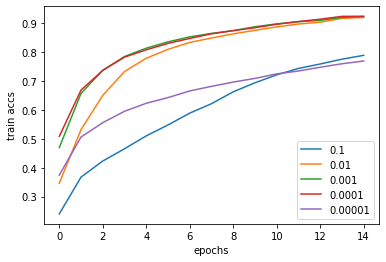

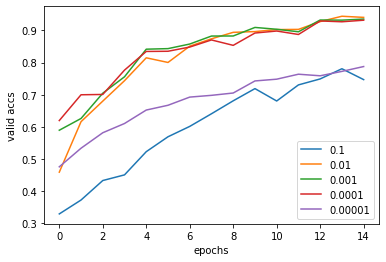

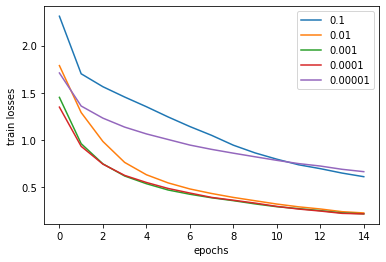

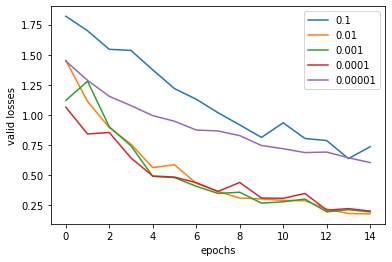

In [ ]:
import utils
utils.generate_plots(['/content/exps/resnet18/0_1',
                      '/content/exps/resnet18/0_01',
                      '/content/exps/resnet18/0_001',
                      '/content/exps/resnet18/0_0001',
                      '/content/exps/resnet18/0_00001'], 
                     ['0.1', '0.01', '0.001', '0.0001', '0.00001'], 
                     '/content/gdrive/MyDrive/rl/assignment1_release/figure_save_res/lr')

**Question 4**

In [ ]:
# Example to run MLPMixer with 15 epochs(Default parameters)
config = Arguments(model='mlpmixer', 
                   model_config='/content/assignment/model_configs/mlpmixer.json', 
                   epochs=15, logdir="exps/mlpmixer")
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from /content/assignment/model_configs/mlpmixer.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	256
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 2188298 total parameters, of which 2188298 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.31901
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.57623
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.61766
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.41238
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.47204
== [TRAIN] Epoch: 0, Accuracy: 0.421 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.39669
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.522 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.21684
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.32808
[TRAIN] Epoch: 1, Iter: 160, Loss

In [ ]:
# Experiment 1 with patchsize=2 to run MLPMixer with 15 epochs
config = Arguments(model='mlpmixer', 
                   model_config='/content/assignment/model_configs/mlpmixer.json', 
                   epochs=15, logdir="exps/mlpmixer")
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from /content/assignment/model_configs/mlpmixer.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	2
embed_dim:	256
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 2376458 total parameters, of which 2376458 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.44972
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.72474
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.46766
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.40507
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.43083
== [TRAIN] Epoch: 0, Accuracy: 0.419 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.38751
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.502 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.17286
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.29200
[TRAIN] Epoch: 1, Iter: 160, Loss

In [ ]:
# Experiment 2 with patchsize=4 to run MLPMixer with 15 epochs
config = Arguments(model='mlpmixer', 
                   model_config='/content/assignment/model_configs/mlpmixer.json', 
                   epochs=15, logdir="exps/mlpmixer")
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from /content/assignment/model_configs/mlpmixer.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	256
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 2188298 total parameters, of which 2188298 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.31901
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.57623
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.61766
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.41238
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.47204
== [TRAIN] Epoch: 0, Accuracy: 0.421 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.39669
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.522 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.21684
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.32808
[TRAIN] Epoch: 1, Iter: 160, Loss

In [ ]:
# Experiment 3 with patchsize=8 to run MLPMixer with 15 epochs
config = Arguments(model='mlpmixer', 
                   model_config='/content/assignment/model_configs/mlpmixer.json', 
                   epochs=15, logdir="exps/mlpmixer")
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from /content/assignment/model_configs/mlpmixer.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	8
embed_dim:	256
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 2175818 total parameters, of which 2175818 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.79192
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.76899
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.74763
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.54448
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.41485
== [TRAIN] Epoch: 0, Accuracy: 0.395 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.46037
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.504 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.39015
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.39092
[TRAIN] Epoch: 1, Iter: 160, Loss

In [ ]:
# Experiment 4 with patchsize=16 to run MLPMixer with 15 epochs
config = Arguments(model='mlpmixer', 
                   model_config='/content/assignment/model_configs/mlpmixer.json', 
                   epochs=15, logdir="exps/mlpmixer")
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from /content/assignment/model_configs/mlpmixer.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	16
embed_dim:	256
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 2310938 total parameters, of which 2310938 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.73448
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.84009
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.64006
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.71743
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.62074
== [TRAIN] Epoch: 0, Accuracy: 0.370 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.52974
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.459 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.55737
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.57607
[TRAIN] Epoch: 1, Iter: 160, Los

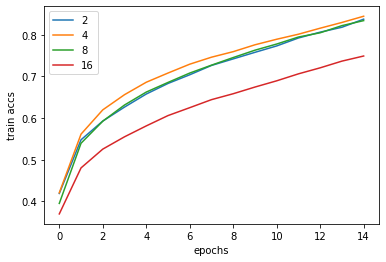

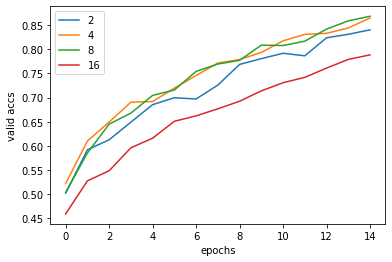

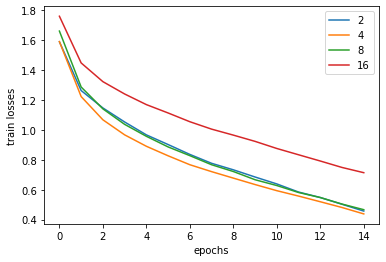

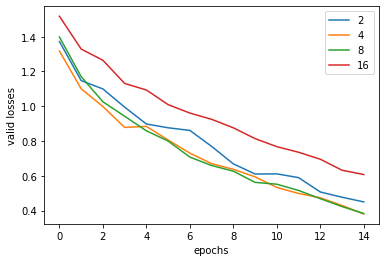

In [ ]:
import utils
utils.generate_plots(['/content/exps/mlpmixer/2',
                      '/content/exps/mlpmixer/4', 
                      '/content/exps/mlpmixer/8',
                      '/content/exps/mlpmixer/16'], 
                     ['2', '4', '8', '16'], 
                     '/content/gdrive/MyDrive/rl/assignment1_release/figure_save_mlpmixer/patch_size')

**Question 5**

**Optimizer Experimentation**

In [ ]:
# Example to run ResNet18(optimizer)
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", optimizer='adam',
                   lr=0.0001)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.46031
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.54715
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.21405
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.10623
== [TRAIN] Epoch: 0, Accuracy: 0.507 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.23564
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.616 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.96486
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.84922
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.94318
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.87332
[TRAIN] Epoch: 1, Iter: 320, Loss

In [ ]:
# Example to run ResNet18(optimizer)
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", optimizer='adamw',
                   lr=0.0001)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.45291
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.51667
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.21901
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.07728
== [TRAIN] Epoch: 0, Accuracy: 0.507 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.18330
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.607 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.96633
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.88565
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.94263
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.88510
[TRAIN] Epoch: 1, Iter: 320, Loss

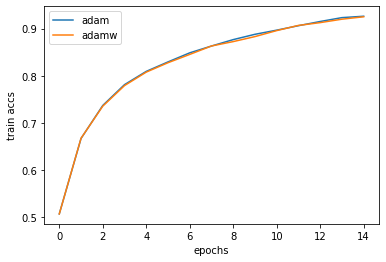

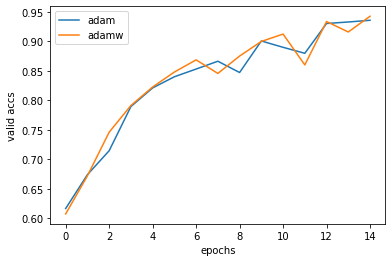

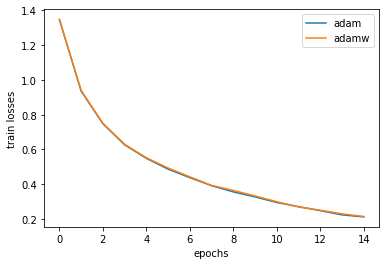

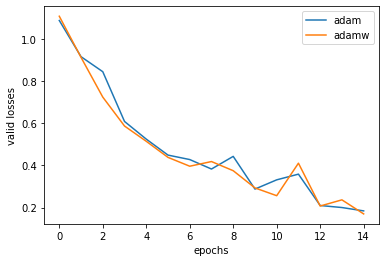

In [ ]:
import utils
utils.generate_plots(['/content/exps/resnet18/adam',
                      '/content/exps/resnet18/adamw'], 
                     ['adam', 'adamw'], 
                     '/content/gdrive/MyDrive/Colab Notebooks/rl/assignment1_release/figure_save_res/optimizer')

**Weight_Decay Experimentation**

In [ ]:
# Example to run ResNet18(batch_size)
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", optimizer='adamw',
                   lr=0.0001, momentum=0.9, weight_decay=0.5)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.46043
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.51461
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.26356
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.06843
== [TRAIN] Epoch: 0, Accuracy: 0.507 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.20867
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.610 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.97114
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.91709
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.90590
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.91186
[TRAIN] Epoch: 1, Iter: 320, Loss: 0.72299
== [TRAIN] Epoch: 1, Accuracy: 0.667 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 0.95479
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.682 ===>
====== Epoch 2 ======>
[TRAIN] Epoch: 2, Iter: 0, Loss: 0.96256
[TRAIN] Epoch: 2, Iter: 80, Loss: 0.75083
[TRAIN] Epoch: 2, Iter: 160, Loss: 0.79305
[TRAIN] Epoch: 2, Iter: 240, Loss: 0.73419
[TRAIN] Epoch: 2, Iter: 320, Loss: 0.76176
== [TRAIN] Epoch: 2, Accuracy: 0.738 ==>
[VAL] Epoch: 2,

In [ ]:
# Example to run ResNet18(batch_size)
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", optimizer='adamw',
                   lr=0.0001, momentum=0.9, weight_decay=0.05)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.46048
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.56535
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.19479
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.09294
== [TRAIN] Epoch: 0, Accuracy: 0.506 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.22627
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.604 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.96875
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.89798
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.89996
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.91417
[TRAIN] Epoch: 1, Iter: 320, Loss

In [ ]:
# Example to run ResNet18(batch_size)
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", optimizer='adamw',
                   lr=0.0001, momentum=0.9, weight_decay=0.005)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.49448
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.53372
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.23850
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.10035
== [TRAIN] Epoch: 0, Accuracy: 0.506 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.20503
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.597 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.95220
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.92198
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.91369
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.89851
[TRAIN] Epoch: 1, Iter: 320, Loss

In [ ]:
# Example to run ResNet18(batch_size)
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", optimizer='adamw',
                   lr=0.0001, momentum=0.9, weight_decay=0.0005)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.43684
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.55154
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.21183
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.09353
== [TRAIN] Epoch: 0, Accuracy: 0.508 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.20704
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.621 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.94880
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.91905
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.86833
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.90757
[TRAIN] Epoch: 1, Iter: 320, Loss

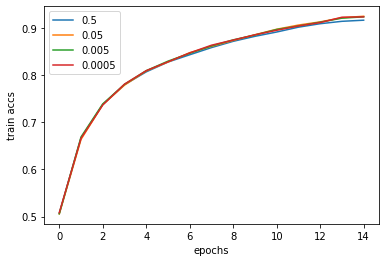

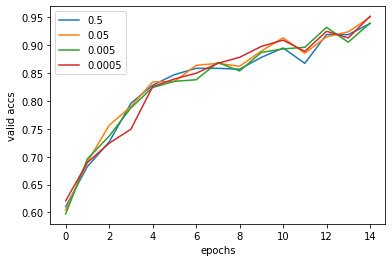

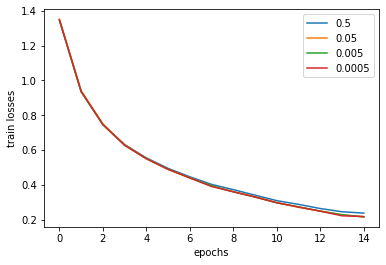

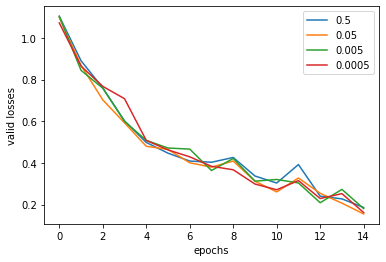

In [ ]:
import utils
utils.generate_plots(['/content/exps/resnet18/0_5',
                      '/content/exps/resnet18/0_05', 
                      '/content/exps/resnet18/0_005',
                      '/content/exps/resnet18/0_0005'], 
                     ['0.5', '0.05', '0.005', '0.0005'], 
                     '/content/gdrive/MyDrive/Colab Notebooks/rl/assignment1_release/figure_save_res/weight_decay')

**Batch_size Experimentation**

In [ ]:
# Example to run ResNet18(batch_size)
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", optimizer='adamw',
                   lr=0.0001, momentum=0.9, weight_decay=0.0005, batch_size=32)
main_entry(config)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[TRAIN] Epoch: 0, Iter: 0, Loss: 2.40707
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.93953
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.73369
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.59767
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.31354
[TRAIN] Epoch: 0, Iter: 400, Loss: 1.23395
[TRAIN] Epoch: 0, Iter: 480, Loss: 1.36820
[TRAIN] Epoch: 0, Iter: 560, Loss: 1.33198
[TRAIN] Epoch: 0, Iter: 640, Loss: 1.25541
[TRAIN] Epoch: 0, Iter: 720, Loss: 1.13225
[TRAIN] Epoch: 0, Iter: 800, Loss: 1.20541
[TRAIN] Epoch: 0, Iter: 880, Loss: 0.98196
[TRAIN] Epoch: 0, Iter: 960, Loss: 1.28519
[TRAIN] Epoch: 0, Iter: 1040, Loss: 1.20373
[TRAIN] Epoch: 0, Iter: 1120, Loss: 0.80367
[TRAIN] Epoch: 0, Iter: 1200, Loss: 1.04754
[TRAIN] Epoch: 0, Iter: 1280, Loss: 0.86192
[TRAIN] Epoch: 0, Iter: 1360, Loss: 0.93396
== [TRAIN] Epoch: 0, Accuracy: 0.535 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.25963
[VAL] Epoch: 0, Iter: 80, Loss: 0.70931
=== [VAL] Epoch: 0, Iter: 156, Accuracy: 0.658 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Lo

In [ ]:
# Example to run ResNet18(batch_size)
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", optimizer='adamw',
                   lr=0.0001, momentum=0.9, weight_decay=0.0005, batch_size=64)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.38576
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.65292
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.43218
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.29780
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.35706
[TRAIN] Epoch: 0, Iter: 400, Loss: 1.28114
[TRAIN] Epoch: 0, Iter: 480, Loss: 1.12742
[TRAIN] Epoch: 0, Iter: 560, Loss: 1.03021
[TRAIN] Epoch: 0, Iter: 640, Loss: 1.16710
== [TRAIN] Epoch: 0, Accuracy: 0.530 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.14092
=== [VAL] Epoch: 0, Iter: 78, Accuracy: 0.647 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Los

In [ ]:
# Example to run ResNet18(batch_size)
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", optimizer='adamw',
                   lr=0.0001, momentum=0.9, weight_decay=0.0005, batch_size=128)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.43405
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.51205
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.21114
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.08156
== [TRAIN] Epoch: 0, Accuracy: 0.509 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.17899
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.615 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.93874
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.92408
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.92994
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.92479
[TRAIN] Epoch: 1, Iter: 320, Loss

In [ ]:
# Example to run ResNet18(batch_size)
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", optimizer='adamw',
                   lr=0.0001, momentum=0.9, weight_decay=0.0005, batch_size=256)
main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.36474
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.44272
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.22919
== [TRAIN] Epoch: 0, Accuracy: 0.484 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.15760
=== [VAL] Epoch: 0, Iter: 19, Accuracy: 0.594 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.00583
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.93065
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.88887
== [TRAIN] Epoch: 1, Accuracy: 0.640 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 1.03854
=== [VAL] Epoch: 1, Iter: 19, Accuracy: 0.656 ===>
====== Epoch 2 ======>
[TRAIN] 

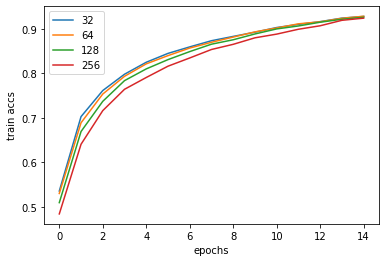

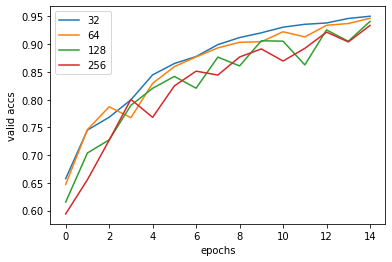

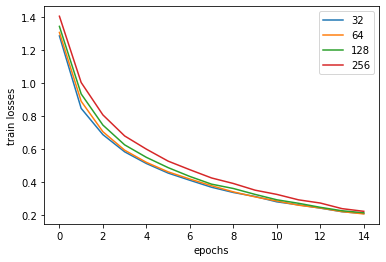

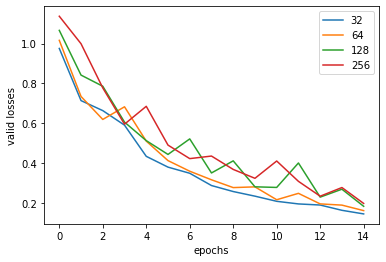

In [ ]:
import utils
utils.generate_plots(['/content/exps/resnet18/32',
                      '/content/exps/resnet18/64', 
                      '/content/exps/resnet18/128',
                      '/content/exps/resnet18/256'], 
                     ['32', '64', '128', '256'], 
                     '/content/gdrive/MyDrive/Colab Notebooks/rl/assignment1_release/figure_save_res/batch_size')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from /content/assignment/model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[TRAIN] Epoch: 0, Iter: 0, Loss: 2.40707
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.84283
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.83731
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.57785
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.40165
[TRAIN] Epoch: 0, Iter: 400, Loss: 1.22147
[TRAIN] Epoch: 0, Iter: 480, Loss: 1.41877
[TRAIN] Epoch: 0, Iter: 560, Loss: 1.19820
[TRAIN] Epoch: 0, Iter: 640, Loss: 1.23699
[TRAIN] Epoch: 0, Iter: 720, Loss: 1.19349
[TRAIN] Epoch: 0, Iter: 800, Loss: 1.26796
[TRAIN] Epoch: 0, Iter: 880, Loss: 0.95545
[TRAIN] Epoch: 0, Iter: 960, Loss: 1.29458
[TRAIN] Epoch: 0, Iter: 1040, Loss: 1.23629
[TRAIN] Epoch: 0, Iter: 1120, Loss: 0.90218
[TRAIN] Epoch: 0, Iter: 1200, Loss: 0.87285
[TRAIN] Epoch: 0, Iter: 1280, Loss: 0.95388
[TRAIN] Epoch: 0, Iter: 1360, Loss: 0.99800
== [TRAIN] Epoch: 0, Accuracy: 0.533 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.12366
[VAL] Epoch: 0, Iter: 80, Loss: 0.86784
=== [VAL] Epoch: 0, Iter: 156, Accuracy: 0.665 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Lo

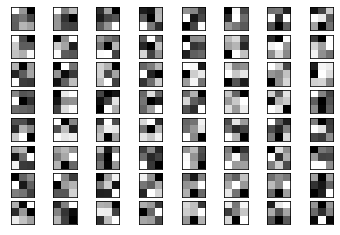

<Figure size 432x288 with 0 Axes>

In [ ]:
# Example to run ResNet18(batch_size)
config = Arguments(model='resnet18', 
                   model_config='/content/assignment/model_configs/resnet18.json', 
                   epochs=15, logdir="exps/resnet18", optimizer='adamw',
                   lr=0.0001, momentum=0.9, weight_decay=0.0005, batch_size=32,
                   visualize=True)
main_entry(config)

**Question 6**

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from /content/assignment/model_configs/mlpmixer.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	256
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 2188298 total parameters, of which 2188298 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.31901
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.57623
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.61766
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.41238
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.47204
== [TRAIN] Epoch: 0, Accuracy: 0.421 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.39669
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.522 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.21684
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.32808
[TRAIN] Epoch: 1, Iter: 160, Loss

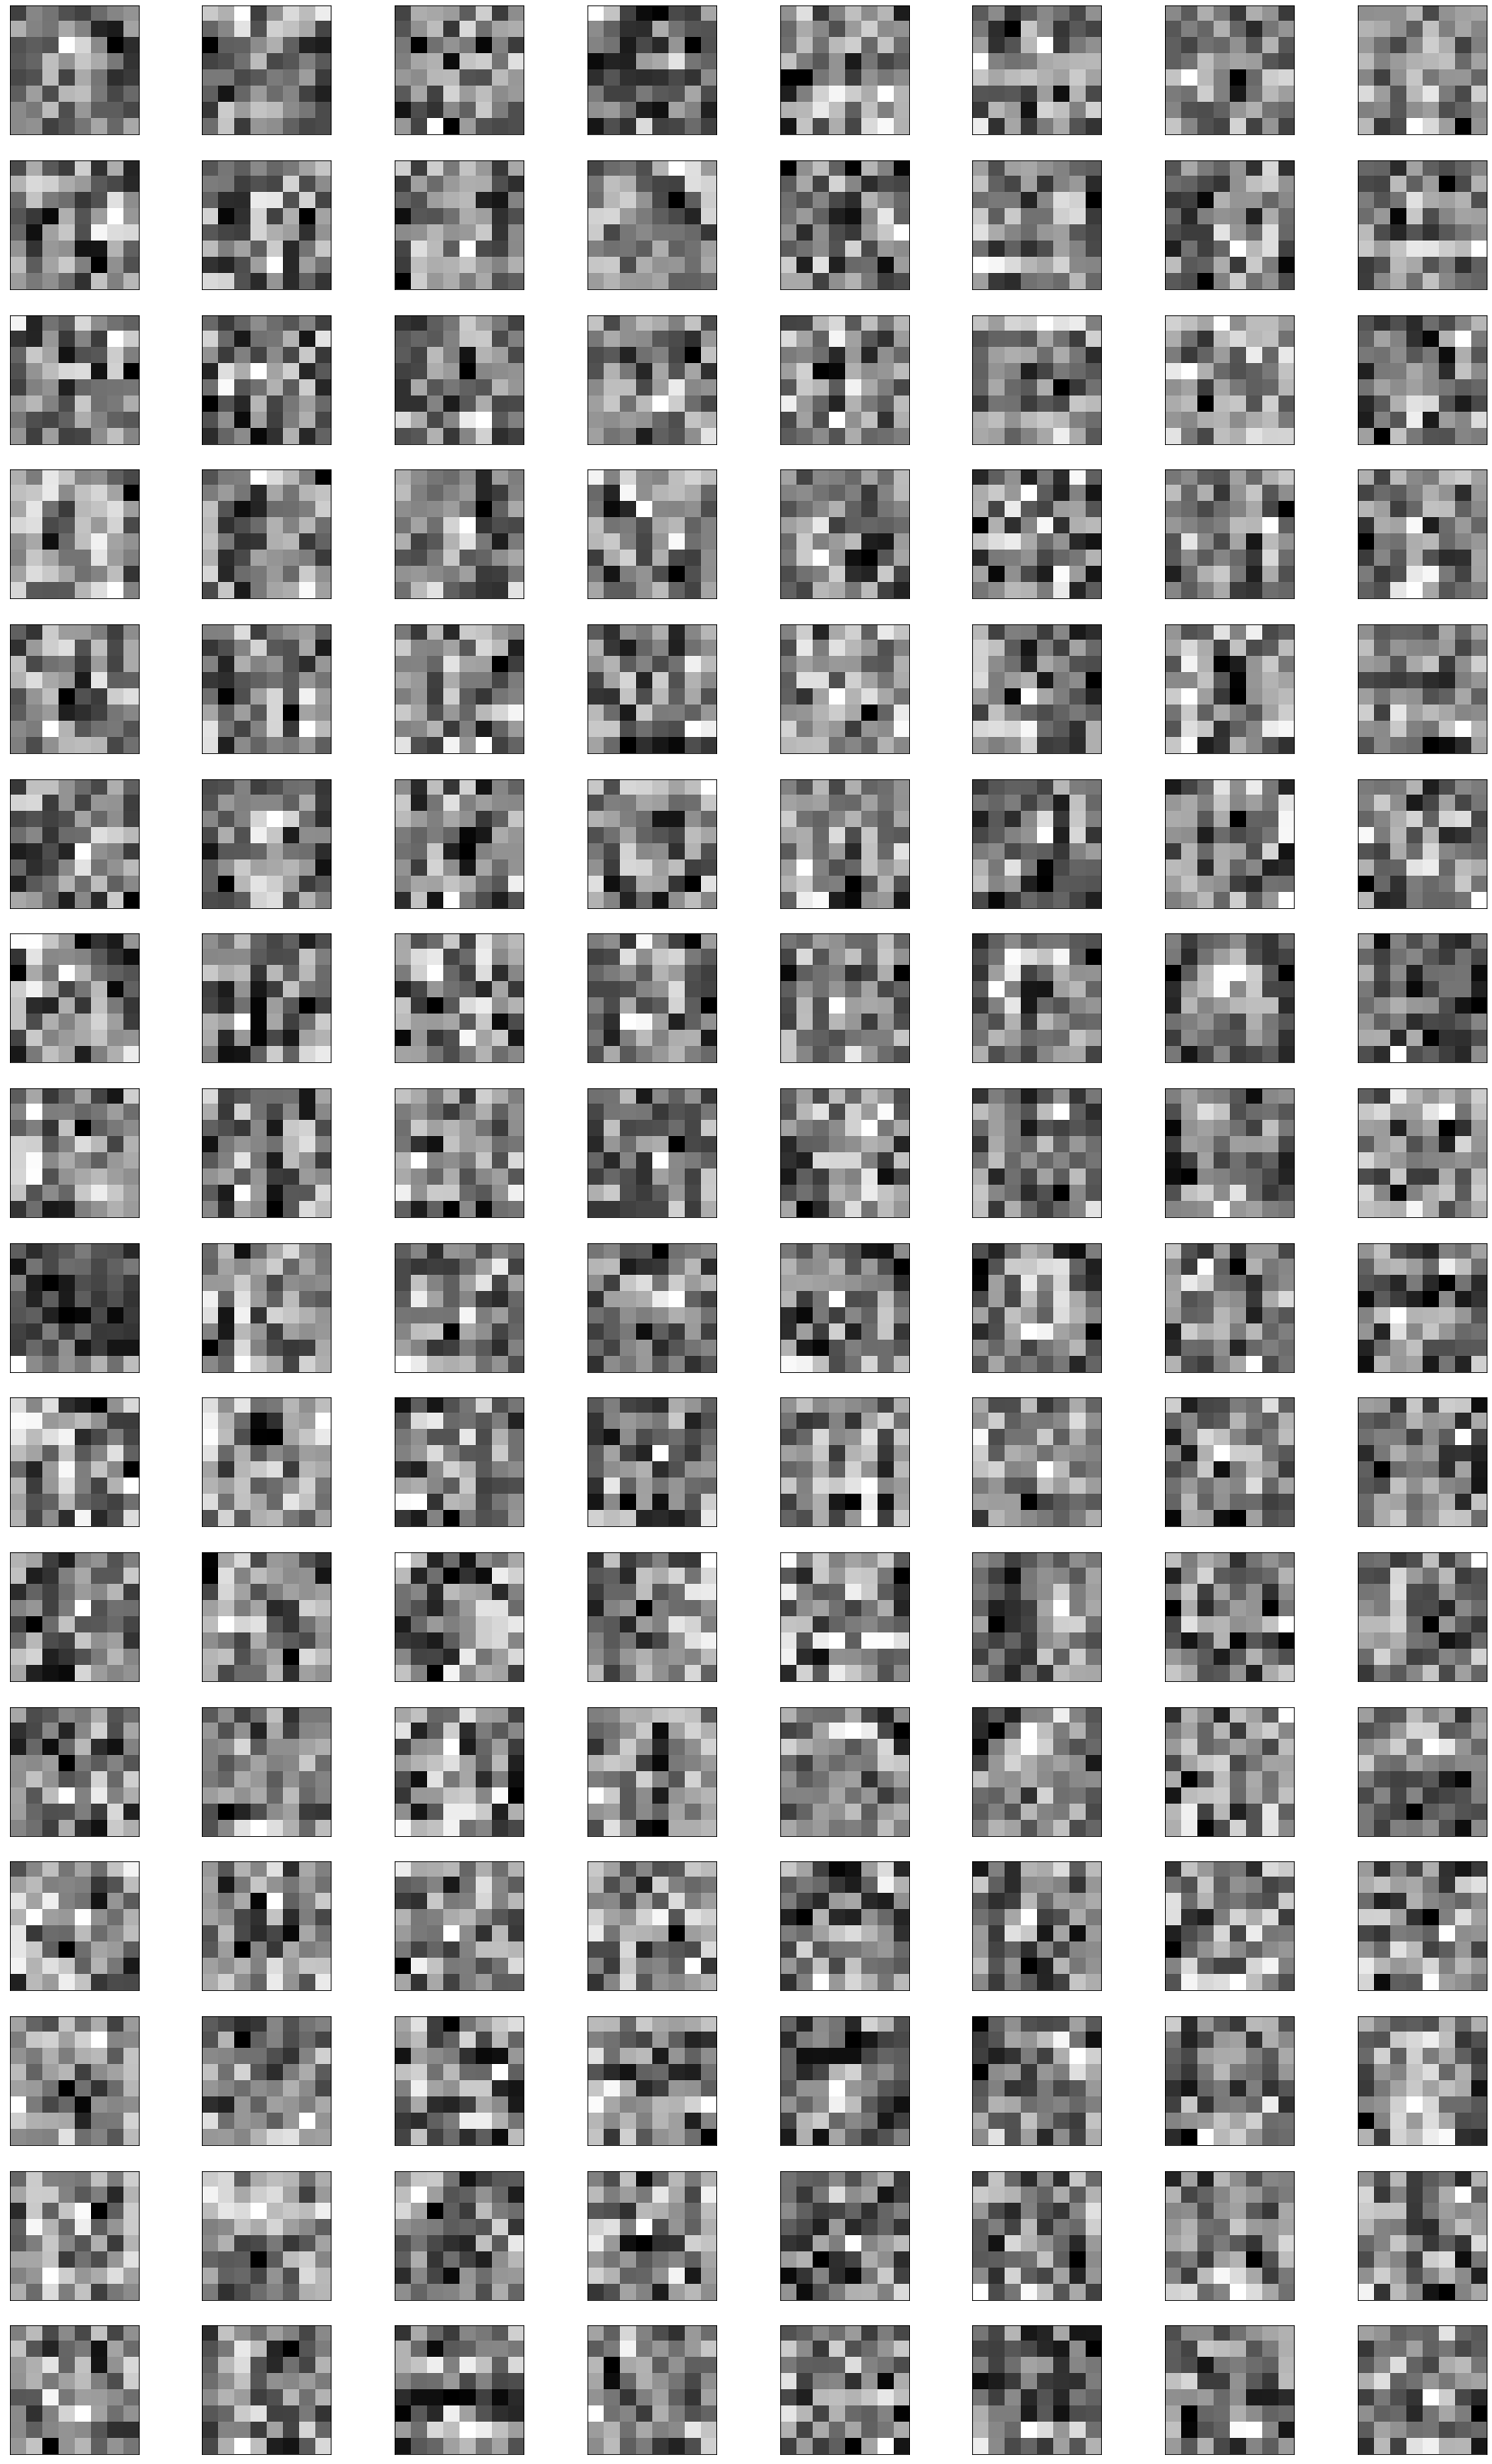

<Figure size 2160x3600 with 0 Axes>

In [12]:
# Example to run MLPMixer with 15 epochs
config = Arguments(model='mlpmixer', 
                   model_config='/content/assignment/model_configs/mlpmixer.json', 
                   epochs=15, logdir="exps/mlpmixer", visualize=True)
main_entry(config)